# Molecular Crystals Analysis

In [2]:
%%bash
# Get results
#git submodule update --remote

Submodule path '../tb_results': checked out 'd39c276bd1181f75698e1dc1887bb7665b6e9854'


In [1]:
%load_ext autoreload
from pathlib import Path
# Get submodule directory
RESULTS_ROOT = Path.cwd().parent.absolute() / 'tb_results'

In [2]:
# Parsers/loaders
import json
import numpy as np
from typing import Dict, List


def repackage_qcore_results(qcore_results: dict) -> dict:
    """ Valid for how Rui has packed X23 data

    returns repacked_data['molecule'] = e_vs_v where
    e_vs_v.shape = (n_points_for_systems, 2), with col 0 = volume and col 1 = energy.
    """
    assert set(qcore_results.keys()) == {'n_points_for_systems', 'shell_charges', 'atomic_charges',
                                         'atomic_partial_charges', 'volume', 'energies', 'identities',
                                         'k_grid'}

    n_points_for_systems = qcore_results['n_points_for_systems']
    assert all(point == 21 for point in n_points_for_systems), 'Same number of sampling points per calculation'

    energies = qcore_results['energies']
    volumes = qcore_results['volume']
    map_name_to_index = {name: i for i, name in enumerate(qcore_results['identities'])}

    vol_bohr_to_ang = 0.52917721067**3.
    ha_to_ev = 27.21138624598853

    # Packing consistent with TBLite and QE results
    repacked_data = {}
    for name in molecule_names:
        i = map_name_to_index[name]
        v = np.asarray(volumes[i]) * vol_bohr_to_ang
        e = np.asarray(energies[i]) * ha_to_ev
        repacked_data[name] = np.column_stack((v, e))
    return repacked_data


def _loader(root: Path, molecules: List[str], prefix: str, extension: str) -> Dict[str, np.ndarray]:
    results = {}
    for molecule in molecules:
        f_name = root / Path(prefix +  '_' + molecule + extension)
        results[molecule] = np.loadtxt(f_name, skiprows=2)
    return results


def tblite_loader(root: Path, molecules: List[str]) -> Dict[str, np.ndarray]:
    return _loader(root, molecules, prefix='e_vs_v', extension='.dat')


def qe_loader(root: Path, molecules: List[str]) -> Dict[str, np.ndarray]:
    return _loader(root, molecules, prefix='e_vs_v', extension='.dat')


def qcore_loader(root) -> dict:
    with open(root) as fid:
        data = json.load(fid)
    # Note, it would make sense to dump data output from
    # `repackage_qcore_results` once, then remove its use
    return repackage_qcore_results(data)


In [3]:
# List of X23 molecules
molecule_names = [
'urea',
'uracil',
'trioxane',
'triazine',
'succinic',
'pyrazole',
'pyrazine',
'oxacb',
'oxaca',
'naph',
'imdazole',
'hexdio',
'hexamine',
'formamide',
'ethcar',
'cytosine',
'cyanamide',
'benzene',
'anthracene',
'ammonia',
'adaman',
'acetic',
'CO2'
]

n_atoms = {
'urea': 16,
'uracil': 48,
'trioxane': 72,
'triazine': 54,
'succinic': 28,
'pyrazole': 9,
'pyrazine': 20,
'oxacb': 16,
'oxaca': 32,
'naph': 36,
'imdazole': 36,
'hexdio': 32,
'hexamine': 22,
'formamide': 24,
'ethcar': 26,
'cytosine': 52,
'cyanamide': 40,
'benzene': 48,
'anthracene': 48,
'ammonia': 16,
'adaman': 52,
'acetic': 32,
'CO2': 12
}

In [4]:
"""Utilities for processing data
"""
import numpy as np
from typing import Union

from delta_factor.fit_eos import fit_birch_murnaghan_relation, parse_birch_murnaghan_relation, calculate_birch_murnaghan_relation, \
    EVCurveData
from delta_factor import fit_eos


def e_vs_v(result: Union[np.ndarray, EVCurveData], n_points=100) -> dict:
    """ High-level processing of E vs V data.

    :param result: E vs V calculation result.
    :param n_points: Number of points to sample the model with.
    :return processed_data: Data and corresponding model fit.
    """
    if isinstance(result, EVCurveData):
        vol, energy = result.volume, result.energy
    else:
        vol, energy = result[:, 0], result[:, 1]

    # For whatever dumb reason, QCore's ammonia data ordering is not contiguous in 
    # volume i.e the last 3 values should be the first 3 in the list. Assuming the 
    # energies have the same issue, I can just do a check on the volume ordering,
    # sort lowest to highest, and reorder the energies with the same map
    sorted_indices = np.argsort(vol)
    n = len(sorted_indices)
    already_sorted = np.array_equal(sorted_indices, np.linspace(1, n, n, dtype=int))
    if not already_sorted:
        vol = vol[sorted_indices]
        energy = energy[sorted_indices]

    fit_data: dict = fit_birch_murnaghan_relation(vol, energy)
    equilibrium_energy = fit_data['ground_state_energy']['value']

    energy_model = parse_birch_murnaghan_relation(fit_data)
    linearly_sampled_volume = np.linspace(vol[0], vol[-1], n_points)
    energy_fit = energy_model(linearly_sampled_volume)

    processed_data = {'model': {'volume': linearly_sampled_volume, 'energy': energy_fit - equilibrium_energy},
                      'data' : {'volume': vol, 'energy': energy - equilibrium_energy}
                      }

    return processed_data


def set_plot_range(model: dict, x_range: float, head_room=2) -> tuple:
    """ADD ME

    """
    # X range
    # Limits consistent with the range over which delta factor was computed
    i_energy_min = np.argmin(model['energy'])
    v_eq = model['volume'][i_energy_min]
    xi = np.around(v_eq - x_range * v_eq, decimals=0)
    xf =  np.around(v_eq + x_range * v_eq, decimals=0)

    # Upper Y limit set according to x-range
    # Find max y in the x-range [xi:xf]
    index_xi = (np.abs(model['volume'] - xi)).argmin()
    index_xf = (np.abs(model['volume'] - xf)).argmin()
    energy_max = np.max(model['energy'][index_xi:index_xf])

    return (xi, xf), (0, head_room * energy_max)


def relative_error(estimated, mean):
    """ Relative error as a percentage
    """
    return (np.abs(estimated - mean) / mean) * 100


def fit_model(result: Union[np.ndarray, EVCurveData]) -> EVCurveData:
    """ Light wrapper for fitting birch_murnaghan model to the data
    """
    result_obj = result

    if not isinstance(result, EVCurveData):
        result_obj= EVCurveData(result[:, 0], result[:, 1])

    return calculate_birch_murnaghan_relation(result_obj)


def compute_delta_factor(molecule_names: list, results1: dict, results2: dict) -> dict:
    """ Compute delta factor for molecular systems

    Note, n_atoms is global data.
    """
    ev_to_mev = 1000.

    # Fit model
    vol_1 = []
    vol_2 = []

    vol_error_12 = []
    delta_factor_12 = []

    for molecule in molecule_names:
        fit_data_1: EVCurveData = fit_model(results1[molecule])
        fit_data_2: EVCurveData = fit_model(results2[molecule])

        equilibrium_vol_1 = fit_data_1.fitted_parameters['eq_volume']['value']
        equilibrium_vol_2 = fit_data_2.fitted_parameters['eq_volume']['value']

        # Collate results
        vol_1.append(equilibrium_vol_1)
        vol_2.append(equilibrium_vol_2)
        vol_error_12.append(relative_error(equilibrium_vol_1, equilibrium_vol_2))

        df_tmp = fit_eos.delta_factor(fit_data_1, fit_data_2, equilibrium_vol_2)
        delta_factor_12.append(df_tmp / float(n_atoms[molecule])  * ev_to_mev)

    # Package for dataframe
    data = {rf"{results1['label']} Equilibrium volume $\mathring{{A}}\,^3$": np.around(vol_1, decimals=2),
            rf"{results2['label']} Equilibrium volume $\mathring{{A}}\,^3$": np.around(vol_2, decimals=2),
            f"{results1['label']} Error in Volume w.r.t. QE (%)": np.around(vol_error_12, decimals=2),
            f"{results1['label']} Delta Factor (meV / atom)": np.around(delta_factor_12, decimals=2)}

    return data


def compute_bulk_modulus(materials: list, tb_results: dict, qe_results: dict, dp=0) -> dict:
    """ Compute bulk moduli for tight-binding data and QE data.
    
    Note, one could return it in the function above, but as this costs nothing to 
    compute, I've written a separate function.
    
    Units:
    Expect energy in eV and volume in Angstrom^3
    Bulk modulus is E/V, so to convert to GaP:
     eV_to_J / (angstrom_to_m^3 * 10^9) == eV_to_J * 10^21
    """
    fit1_bm = []
    fit2_bm = []
    fit1_error = []
    
    to_GPa = 1.602177e-19 * 1.e21
    
    for material in materials:
        fit_succeeded = True

        try:
            fit1_data: EVCurveData = fit_model(tb_results[material])
        except RuntimeError:
            print(f"TB fitting attempts exceeded for {tb_results['label']} {material}")
            fit_succeeded = False
        try:
            fit2_data: EVCurveData = fit_model(qe_results[material])
        except RuntimeError:
            print(f"QE fitting attempts exceeded for {qe_results['label']} {material}")
            fit_succeeded = False

        if fit_succeeded:
            fit1_bm.append(fit1_data.fitted_parameters['bulk_modulus']['value'] * to_GPa)
            fit2_bm.append(fit2_data.fitted_parameters['bulk_modulus']['value'] * to_GPa)
            fit1_error.append(relative_error(fit1_bm[-1], fit2_bm[-1]))
        else:
            fit1_bm.append(np.infty)
            fit2_bm.append(np.infty)
            fit1_error.append(np.infty)

    # Package for dataframe
    data = {rf"{tb_results['label']} Bulk Modulus (GaP)": np.around(fit1_bm, decimals=dp),
            rf"{qe_results['label']} Bulk Modulus (GaP)": np.around(fit2_bm, decimals=dp),
            f"{tb_results['label']} Error in Bulk Modulus w.r.t. {qe_results['label']} (%)": np.around(fit1_error, decimals=dp)
            }

    return data



In [5]:
"""E vs V Comparison for QE using k=[1,1,1] and [4,4,4] grids.

Several systems require k=[4,4,4], as clearly shown from the delta factor values
"""
import matplotlib.pyplot as plt

from nb_modules.nb_plotting import bin_list

plot_e_vs_v = False

if plot_e_vs_v:
    QE_RESULTS_ROOT1 = Path(RESULTS_ROOT, f'espresso/x23_e_vs_v/collated_results/1_1_1')
    QE_RESULTS_ROOT2 = Path(RESULTS_ROOT, f'espresso/x23_e_vs_v/collated_results/4_4_4')

    qe_results_k111 = tblite_loader(QE_RESULTS_ROOT1, molecule_names)
    qe_results_k444 = tblite_loader(QE_RESULTS_ROOT2, molecule_names)

    bin_size = 2
    binned_materials = bin_list(molecule_names, bin_size)

    for bin in binned_materials:
        fig, axs = plt.subplots(1, bin_size, figsize=(16,4))

        for i, molecule in enumerate(bin):
            qe_k111 = e_vs_v(qe_results_k111[molecule])
            qe_k444 = e_vs_v(qe_results_k444[molecule])

            axs[i].set_xlabel(r"Volume ($\AA^3$)")
            axs[i].set_ylabel("Cell Energy (eV)")

            axs[i].plot(qe_k111['model']['volume'], qe_k111['model']['energy'], '-', color='b')
            axs[i].plot(qe_k111['data']['volume'],  qe_k111['data']['energy'],  'o', color='b', label='k=[1,1,1]')

            axs[i].plot(qe_k444['model']['volume'], qe_k444['model']['energy'], '--', color='r')
            axs[i].plot(qe_k444['data']['volume'],  qe_k444['data']['energy'],  'o', color='r', label='k=[4,4,4]')

            axs[i].legend()
            axs[i].set_title(molecule)


In [6]:
""" Compute delta factors for QE runs having used k=(1,1,1) and k=(4,4,4).

Results show that half of the data set should be run with k = (4,4,4).
In some instances, it corresponds to > 1 meV per atom.
"""
QE_RESULTS_ROOT = Path(RESULTS_ROOT, f'espresso/x23_e_vs_v/collated_results')

qe_results_k111 = qe_loader(Path(QE_RESULTS_ROOT, "1_1_1"), molecule_names)
qe_results_k444 = qe_loader(Path(QE_RESULTS_ROOT, "4_4_4"), molecule_names)

qe_results_k111['label'] = 'QE k=(1,1,1)'
qe_results_k444['label'] = 'QE k=(4,4,4)'

data_qe_comparison = compute_delta_factor(molecule_names, qe_results_k111, qe_results_k444)
# Extract the delta factors
delta_factor_qe_comparison = data_qe_comparison['QE k=(1,1,1) Delta Factor (meV / atom)']

print('Systems where k = (4,4,4) is necessary')
print('System,  Delta Factor (meV / atom)')
for  i, name in enumerate(molecule_names):
    if delta_factor_qe_comparison[i] > 1.00:
        print(name, delta_factor_qe_comparison[i])


Systems where k = (4,4,4) is necessary
System,  Delta Factor (meV / atom)
urea 1.32
uracil 11.31
triazine 1.07
succinic 1.24
pyrazine 7.47
oxacb 3.03
hexamine 1.6
formamide 9.68
ethcar 1.07
cytosine 7.47
ammonia 4.13
adaman 1.6
acetic 4.22
CO2 1.95


In [7]:
"""Bulk Moduli
Data frame and plot for X23 bulk moduli
"""
import pandas as pd

# Load data
TB_RESULTS_ROOT = Path(RESULTS_ROOT, f'tblite1/x23_e_vs_v/4_4_4')
QE_RESULTS_ROOT = Path(RESULTS_ROOT, f'espresso/x23_e_vs_v/collated_results/4_4_4')
QCORE_RESULTS_ROOT = Path(RESULTS_ROOT, 'qcore/X23_inputs_4_4_4.json')

tb_results = tblite_loader(TB_RESULTS_ROOT, molecule_names)
qcore_results = qcore_loader(QCORE_RESULTS_ROOT)
qe_results = qe_loader(QE_RESULTS_ROOT, molecule_names)

tb_results.update({'label': 'TBLite1', 'color': 'green'})
qcore_results.update({'label': 'QCore', 'color': 'blue'})
qe_results.update({'label': 'QE', 'color': 'red'})

# Compute bulk moduli
data_bm_lite_qe = compute_bulk_modulus(molecule_names, tb_results, qe_results, dp=0)
data_bm_qcore_qe = compute_bulk_modulus(molecule_names, qcore_results, qe_results, dp=0)
assert len(data_bm_lite_qe['TBLite1 Bulk Modulus (GaP)']) == len(data_bm_qcore_qe['QCore Bulk Modulus (GaP)'])
data_bm = data_bm_lite_qe | data_bm_qcore_qe

# Output as pandas DF
df_bm = pd.DataFrame(data=data_bm)
df_bm = df_bm.rename(index={i: name for i, name in enumerate(molecule_names)})

# Note, print(df_bm) will not display the same formatting
print(df_bm)

# Mean relative errors
print('TBLite:', np.mean(data_bm['TBLite1 Error in Bulk Modulus w.r.t. QE (%)']))
print('QCore:', np.mean(data_bm['QCore Error in Bulk Modulus w.r.t. QE (%)']))

# Didn't bother adding the plot here, as I thought it didn't add anything w.r.t. the tables of data in the SI


            TBLite1 Bulk Modulus (GaP)  QE Bulk Modulus (GaP)  \
urea                             128.0                  133.0   
uracil                           182.0                  165.0   
trioxane                         148.0                  127.0   
triazine                         153.0                  144.0   
succinic                         159.0                  143.0   
pyrazole                         147.0                  135.0   
pyrazine                         157.0                  142.0   
oxacb                            167.0                  153.0   
oxaca                            170.0                  155.0   
naph                             165.0                  145.0   
imdazole                         156.0                  143.0   
hexdio                           151.0                  134.0   
hexamine                         162.0                  148.0   
formamide                        136.0                  124.0   
ethcar                   

In [8]:
"""Plot E vs V function
"""
import numpy as np
import itertools
import math
import matplotlib.pyplot as plt
from typing import List


def plot_e_vs_v(molecule_names: list, 
                results: List[dict], 
                n_cols = 4, 
                vol_range = np.infty, 
                y_limit = None,
                prefactor = None):
    """ Plot E vs V

    molecule_names
    results: List of results dicts
    """    
    # Energy units
    if prefactor is None:
        prefactor = {m: {'value': 1, 'label': 'eV'} for m in molecule_names}

    # Plot settings
    n_rows = math.ceil(len(molecule_names) / n_cols)
    # If n_rows == 1, matplotlib will expect axs[j] not axs[i, j]
    n_rows = max(n_rows, 2)
    
    # Calculate the aspect ratio of standard A4
    aspect_ratio = 297.0 / 210.0

    # Calculate the width of the figure in inches
    fig_width = 8.3  # A4 width in inches (approx)

    # Calculate the height of the figure in inches to maintain aspect ratio
    fig_height = fig_width / aspect_ratio * (n_rows / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
    # fig.tight_layout(h_pad=2.5)
    # Let matplotlib decide on the tight layout - better results
    fig.set_tight_layout(True)

    # ± limits for x-axis. Note, delta factor computed for ±0.06 V_eq
    set_range = vol_range != np.infty
    if set_range:
        print(f'Setting x range to ± {1-vol_range} V_eq')

    # Point and line sizes
    # All originally defined for 2 columns per row, so scale appropriately
    scale = 2. / n_cols
    line_width = int(3 * scale)
    marker_size = int(7 * scale)
    label_size = int(18 * scale)       # 14
    font_size = int(18 * scale)        # 14
    leg_font_size = int(18 * scale)    # 14=2

    # Initialise counters
    empty_lims = 0, 0
    imol = -1

    # Plot
    for i, j in itertools.product(range(n_rows), range(n_cols)):
        imol += 1

        # Exit when last entry is reached.
        if imol > len(molecule_names) - 1:
            empty_lims = i, j
            break

        molecule = molecule_names[imol]
        offset = 0

        # Initialise limits with relative small and large bounds, respectively
        limits = {'x_min': 1000, 'x_max': -1000, 'y_min': 1000, 'y_max': -1000}
        limits = {k: v * prefactor[molecule]['value'] for k, v in limits.items()}
        
        for result in results:

            # Data fitting            
            try:
                fit_a = e_vs_v(result[molecule][offset:])
            except RuntimeError as e:
                print(f"{result['label']} {molecule}: RuntimeError occurred: {e}")

            # Convert energies
            fit_a['model']['energy'] *= prefactor[molecule]['value']
            fit_a['data']['energy'] *= prefactor[molecule]['value']

            # Plot
            axs[i, j].plot(fit_a['model']['volume'], fit_a['model']['energy'], '-', color=result['color'], linewidth=line_width)
            axs[i, j].plot(fit_a['data']['volume'],  fit_a['data']['energy'], 'o', color=result['color'], label=result['label'],  markersize=marker_size)

            # Collect min and max limits from across all plots
            x_lims, y_lims = set_plot_range(fit_a['data'], vol_range, head_room=2)
            limits = {'x_min': min(limits['x_min'], x_lims[0]),
                      'x_max': max(limits['x_max'], x_lims[1]),
                      'y_min': min(limits['y_min'], y_lims[0]),
                      'y_max': max(limits['y_max'], y_lims[1])}

        # Set x and y limits
        if set_range:
            x_lim = limits['x_min'], limits['x_max']
            y_lim = limits['y_min'], limits['y_max']
            axs[i, j].set_xlim(x_lim)
            axs[i, j].set_ylim(top =y_lim[1])
        # If y_limit is passed, this takes priority
        if y_limit is not None:
            axs[i, j].set_ylim(y_limit)

        # Ticks
        axs[i, j].tick_params(axis='both', which='major', labelsize=label_size)
        axs[i, j].tick_params(axis='both', which='minor', labelsize=label_size)

        # Labels
        axs[i, j].set_xlabel(r"Volume ($\AA^3$)", fontsize=font_size)
        axs[i, j].set_ylabel(f"$E_{{total}}$ ({prefactor[molecule]['label']})", fontsize=font_size)
        # axs[i, j].legend(prop={'size': leg_font_size})
        
        if molecule == 'CO2': 
            molecule = r'CO$_2$'
        else:
            molecule = molecule.capitalize()
            
        axs[i, j].set_title(molecule, fontsize=font_size)

    # Remove any empty subplots
    for i, j in itertools.product(range(empty_lims[0], n_rows), range(empty_lims[1], n_cols)):
        axs[i, j].remove()

    return fig, axs


In [9]:
""" X23 E vs V. TBlite1 vs Espresso.

* All calculations performed using k= [4, 4, 4]
  because QE k-convergence tests indicated that this was required.

* D3 used for QE, although it has a tiny contribution to total energy (should confirm)
"""
TB_RESULTS_ROOT = Path(RESULTS_ROOT, f'tblite1/x23_e_vs_v/4_4_4')
QE_RESULTS_ROOT = Path(RESULTS_ROOT, f'espresso/x23_e_vs_v/collated_results/4_4_4')

tb_results = tblite_loader(TB_RESULTS_ROOT, molecule_names)
qe_results = qe_loader(QE_RESULTS_ROOT, molecule_names)

tb_results.update({'label': 'TBLite1', 'color': 'green'})
qe_results.update({'label': 'QE', 'color': 'red'})


print('If we use the dynamic x and y settings, we see a systematic trend of TBLite overestimating cell energies at smaller volumes'
      'underestimating at larger volumes, and predicting an equilibrium volume that exceeds QE''s prediction.')

print('TB Lite and QCore are almost identical, so present a) Qcore vs QE, and b) Qcore vs TBLite')
print('Probably only include plot a) in the paper')

#fig, axs = plot_e_vs_v(molecule_names, [tb_results, qe_results], n_cols = 4, vol_range = 0.1,  y_limit=(-0.3, 5.0))
#fig.savefig("x23_e_vs_v_tblite_qe.pdf", dpi=300, bbox_inches="tight")


If we use the dynamic x and y settings, we see a systematic trend of TBLite overestimating cell energies at smaller volumesunderestimating at larger volumes, and predicting an equilibrium volume that exceeds QEs prediction.
TB Lite and QCore are almost identical, so present a) Qcore vs QE, and b) Qcore vs TBLite
Probably only include plot a) in the paper


In general xTB (TBLite and QCore) overestimate the equilibrium cell volume, resulting in a (not quite rigid) shift of EOS curves to higher energy
Setting x range to ± 0.9 V_eq


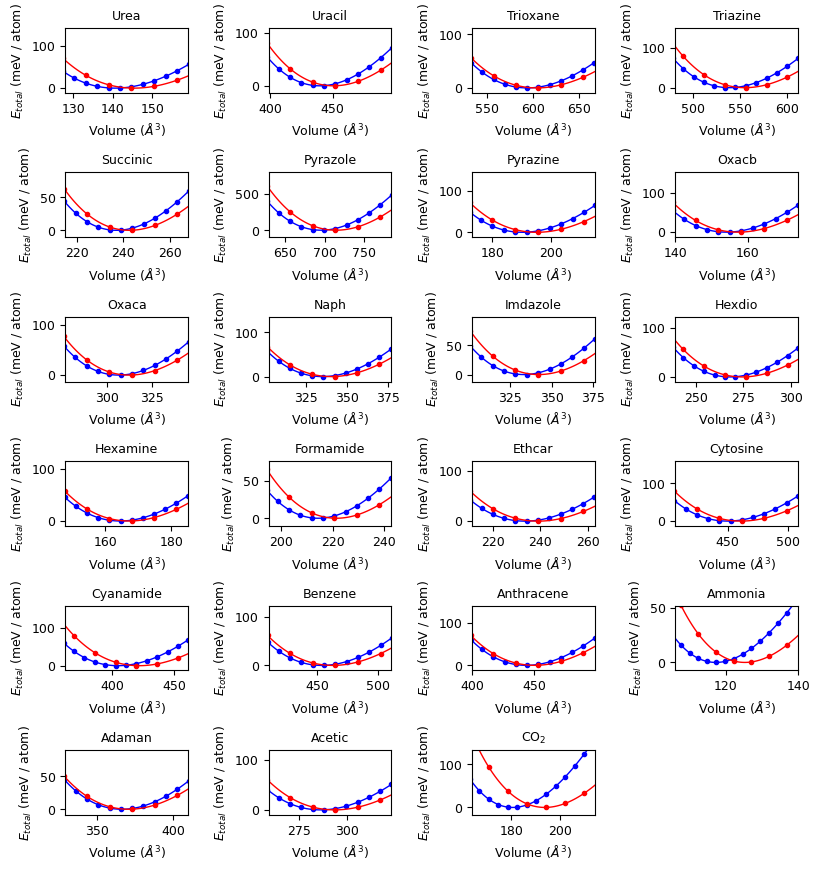

In [21]:
""" X23 E vs V. QCore vs Espresso.

* All calculations performed using k= [4, 4, 4]
  because QE k-convergence tests indicated that this was required.
"""

QCORE_RESULTS_ROOT = Path(RESULTS_ROOT, 'qcore/X23_inputs_4_4_4.json')
QE_RESULTS_ROOT = Path(RESULTS_ROOT, 'espresso/x23_e_vs_v/collated_results/4_4_4')

qcore_results = qcore_loader(QCORE_RESULTS_ROOT)
qe_results = qe_loader(QE_RESULTS_ROOT, molecule_names)

qcore_results.update({'label': 'QCore', 'color': 'blue'})
qe_results.update({'label': 'QE', 'color': 'red'})

print("In general xTB (TBLite and QCore) overestimate the equilibrium cell volume, resulting in a (not quite rigid) shift of EOS curves to higher energy")

prefactor = {m: {'value': 1000. / float(n_atoms[m]), 'label': 'meV / atom'} for m in molecule_names}

fig, axs = plot_e_vs_v(molecule_names, [qcore_results, qe_results], n_cols = 4, vol_range = 0.1, prefactor=prefactor)

fig.savefig("x23_e_vs_v_qcore_qe.eps", dpi=300, bbox_inches="tight")

TB lite and QCore in extremely close agreement for X23 set
Setting x range to ± 0.9 V_eq


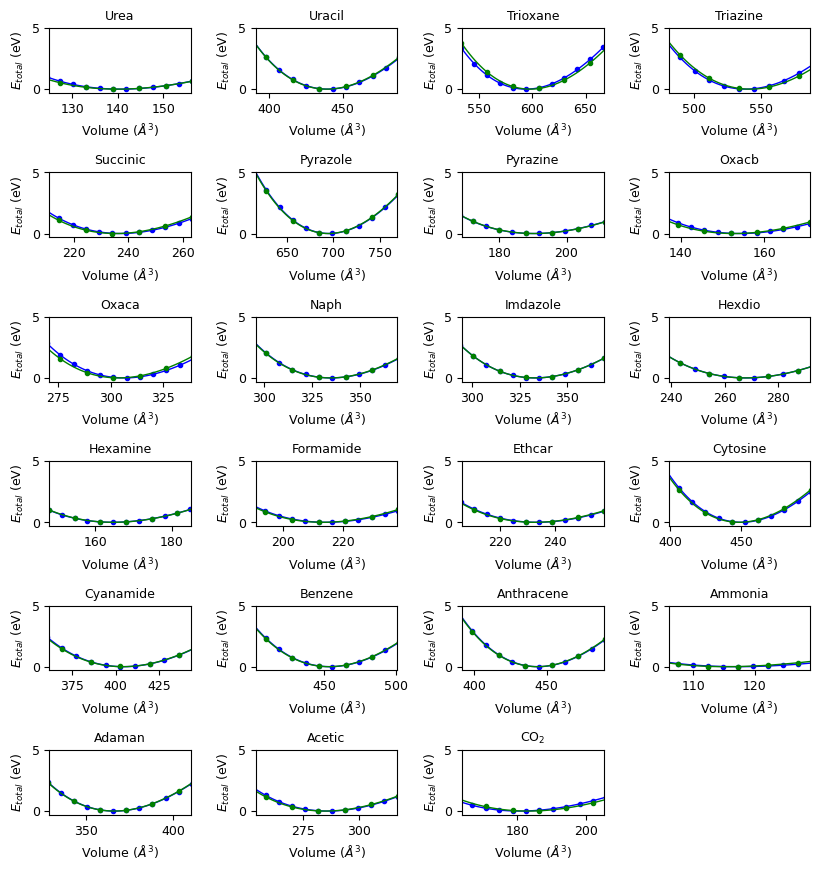

In [22]:
""" X23 E vs V. QCore vs TBLite.

* All calculations performed using k= [4, 4, 4]
  because QE k-convergence tests indicated that this was required.
"""

TB_RESULTS_ROOT = Path(RESULTS_ROOT, f'tblite1/x23_e_vs_v/4_4_4')

tb_results = tblite_loader(TB_RESULTS_ROOT, molecule_names)
qcore_results = qcore_loader(QCORE_RESULTS_ROOT)

tb_results.update({'label': 'TBLite1', 'color': 'green'})
qcore_results.update({'label': 'QCore', 'color': 'blue'})

print("TB lite and QCore in extremely close agreement for X23 set")

fig, axs = plot_e_vs_v(molecule_names, [qcore_results, tb_results], n_cols = 4, vol_range = 0.1, y_limit=(-0.3, 5.0))
#fig.savefig("x23_e_vs_v_qcore_tblite.pdf", dpi=300, bbox_inches="tight")

In [23]:
"""Delta factors for QCore vs QE using k=4,4,4
"""
import pandas as pd


QCORE_RESULTS_ROOT = Path(RESULTS_ROOT, 'qcore/X23_inputs_4_4_4.json')
QE_RESULTS_ROOT = Path(RESULTS_ROOT, 'espresso/x23_e_vs_v/collated_results/4_4_4')

qcore_results = qcore_loader(QCORE_RESULTS_ROOT)
qe_results = qe_loader(QE_RESULTS_ROOT, molecule_names)

qcore_results['label'] = 'QCore k=(4,4,4)'
qe_results['label'] = 'QE k=(4,4,4)'

data = compute_delta_factor(molecule_names, qcore_results, qe_results)

df = pd.DataFrame(data=data)
df = df.rename(index={i: name for i, name in enumerate(molecule_names)})

# Output as latex
df_styled = df.style.format({"name": str.upper}).format("{:.1f}")
df_styled = df_styled.set_table_attributes('index=True')

pd.set_option("display.precision", 1)
print(df_styled.to_latex())

print(df)

\begin{tabular}{lrrrr}
 & QCore k=(4,4,4) Equilibrium volume $\mathring{A}\,^3$ & QE k=(4,4,4) Equilibrium volume $\mathring{A}\,^3$ & QCore k=(4,4,4) Error in Volume w.r.t. QE (%) & QCore k=(4,4,4) Delta Factor (meV / atom) \\
urea & 140.6 & 145.4 & 3.3 & 9.8 \\
uracil & 439.8 & 450.8 & 2.5 & 9.2 \\
trioxane & 593.9 & 604.5 & 1.7 & 4.8 \\
triazine & 538.7 & 555.4 & 3.0 & 11.0 \\
succinic & 237.1 & 242.7 & 2.3 & 7.0 \\
pyrazole & 695.1 & 714.2 & 2.7 & 69.3 \\
pyrazine & 190.2 & 195.2 & 2.5 & 8.6 \\
oxacb & 154.1 & 157.4 & 2.1 & 7.5 \\
oxaca & 306.5 & 312.4 & 1.9 & 6.8 \\
naph & 334.9 & 340.3 & 1.6 & 5.4 \\
imdazole & 333.2 & 342.2 & 2.6 & 8.7 \\
hexdio & 268.0 & 274.4 & 2.4 & 6.8 \\
hexamine & 164.5 & 167.3 & 1.6 & 4.4 \\
formamide & 214.3 & 221.5 & 3.2 & 9.1 \\
ethcar & 233.4 & 239.0 & 2.3 & 6.2 \\
cytosine & 449.9 & 461.0 & 2.4 & 8.5 \\
cyanamide & 404.4 & 421.6 & 4.1 & 13.9 \\
benzene & 453.8 & 462.8 & 1.9 & 6.0 \\
anthracene & 443.9 & 450.6 & 1.5 & 5.2 \\
ammonia & 117.2 & 125.2 & 

In [24]:
# Some QCore stats

deltas = df.loc[:, f"{qcore_results['label']} Delta Factor (meV / atom)"].tolist()
print('min, mean, median, max')
print(np.amin(deltas), np.mean(deltas), np.median(deltas), np.amax(deltas))

min, mean, median, max
3.03 11.706521739130432 7.48 69.32


In [25]:
"""Delta factors for TBLite vs QE
"""
import pandas as pd

TB_RESULTS_ROOT = Path(RESULTS_ROOT, f'tblite1/x23_e_vs_v/4_4_4')
QE_RESULTS_ROOT = Path(RESULTS_ROOT, f'espresso/x23_e_vs_v/collated_results/4_4_4')

tb_results_k444 = tblite_loader(TB_RESULTS_ROOT, molecule_names)
qe_results_k444 = qe_loader(QE_RESULTS_ROOT, molecule_names)

tb_results_k444['label'] = 'TBLite 1 k=(4,4,4)'
qe_results_k444['label'] = 'QE k=(4,4,4)'

data = compute_delta_factor(molecule_names, tb_results_k444, qe_results_k444)

df = pd.DataFrame(data=data)
df = df.rename(index={i: name for i, name in enumerate(molecule_names)})

# Output as latex
df_styled = df.style.format({"name": str.upper}).format("{:.1f}")
df_styled = df_styled.set_table_attributes('index=True')

pd.set_option("display.precision", 1)
# print(df_styled.to_latex())

print(df)

            TBLite 1 k=(4,4,4) Equilibrium volume $\mathring{A}\,^3$  \
urea                                                    139.9          
uracil                                                  439.2          
trioxane                                                598.0          
triazine                                                542.1          
succinic                                                235.4          
pyrazole                                                694.4          
pyrazine                                                190.4          
oxacb                                                   152.7          
oxaca                                                   303.8          
naph                                                    334.5          
imdazole                                                333.2          
hexdio                                                  267.9          
hexamine                                                164.7   

In [26]:
# Some TBlite stats

deltas = df.loc[:, f"{tb_results_k444['label']} Delta Factor (meV / atom)"].tolist()
print('min, mean, median, max')
print(np.amin(deltas), np.mean(deltas), np.median(deltas), np.amax(deltas))

min, mean, median, max
3.03 12.173913043478262 8.73 71.95
